![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

C:\Users\renna\AppData\Local\Temp\ipykernel_16108\2724684495.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  labels = pd.read_csv(path_base / "activity_labels.txt", delim_whitespace=True, header=None, names=['cod_label', 'label'])
C:\Users\renna\AppData\Local\Temp\ipykernel_16108\2724684495.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(path_base / "train/X_train.txt", delim_whitespace=True, header=None, names=features.tolist())
C:\Users\renna\AppData\Local\Temp\ipykernel_16108\2724684495.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(path_base / "test/X_test.txt", delim_whitespace=True, header=None, names=features.tolist())


Iniciando processamento PCA + Árvore de Decisão...
Componentes:   1 | Acc: 0.4571 | Var: 62.55% | Tempo: 0.37s
Componentes:   2 | Acc: 0.5847 | Var: 67.47% | Tempo: 0.33s
Componentes:   5 | Acc: 0.7886 | Var: 75.16% | Tempo: 0.39s
Componentes:  10 | Acc: 0.8242 | Var: 80.50% | Tempo: 0.39s
Componentes:  20 | Acc: 0.8195 | Var: 85.78% | Tempo: 0.52s
Componentes:  50 | Acc: 0.8229 | Var: 93.09% | Tempo: 1.13s
Componentes: 100 | Acc: 0.8290 | Var: 97.30% | Tempo: 1.94s


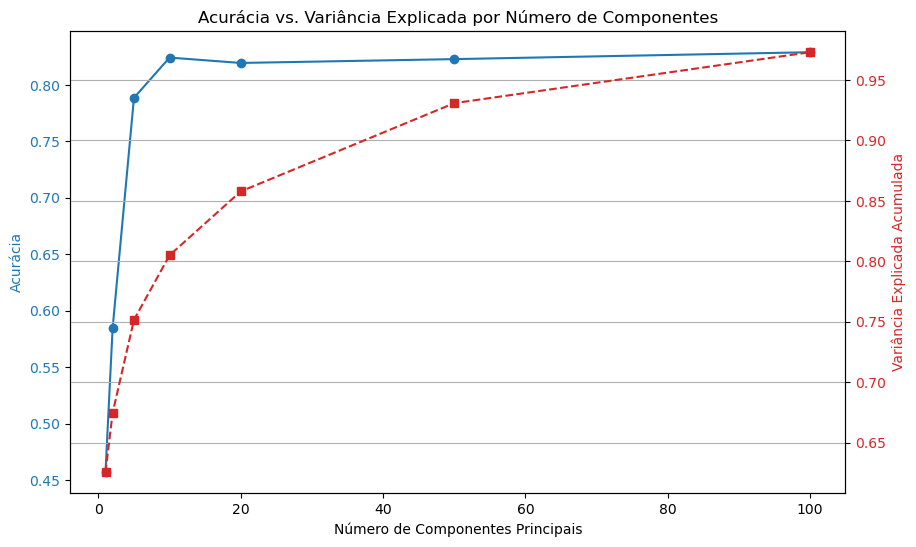

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path

from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# 1. Configurando o caminho
path_base = Path(r'C:\Users\renna\EBAC\MOD27\dataset\UCI HAR Dataset')

# 2. Carregamento dos dados
# Lendo nomes das colunas e labels
features = pd.read_csv(path_base / "features.txt", header=None, names=['nome_var'], sep="#").squeeze("columns")
labels = pd.read_csv(path_base / "activity_labels.txt", delim_whitespace=True, header=None, names=['cod_label', 'label'])

# Carregando Treino
X_train = pd.read_csv(path_base / "train/X_train.txt", delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(path_base / "train/y_train.txt", header=None, names=['cod_label'])

# Carregando Teste
X_test = pd.read_csv(path_base / "test/X_test.txt", delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(path_base / "test/y_test.txt", header=None, names=['cod_label'])

# --- 3. ANÁLISE SISTEMÁTICA ---
# Vamos variar o número de componentes para encontrar o melhor equilíbrio
n_components_list = [1, 2, 5, 10, 20, 50, 100]
resultados = []

print("Iniciando processamento PCA + Árvore de Decisão...")

for n in n_components_list:
    start_time = time.time()
    
    # Aplicando PCA para 'n' componentes
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Treinando a Árvore de Decisão
    # Usando o ccp_alpha=0.001 (poda) para evitar o overfitting que vimos antes
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=0.001)
    clf.fit(X_train_pca, y_train)
    
    # Avaliando o desempenho
    y_pred = clf.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    duration = time.time() - start_time
    
    # Guardando a variância total explicada para o Gráfico de Cotovelo
    variancia_expl = pca.explained_variance_ratio_.sum()
    
    resultados.append({
        'n_components': n, 
        'acuracia': acc, 
        'tempo': duration, 
        'variancia_total': variancia_expl
    })
    
    print(f"Componentes: {n:3} | Acc: {acc:.4f} | Var: {variancia_expl:.2%} | Tempo: {duration:.2f}s")

# 4. Visualização dos Resultados
df_res = pd.DataFrame(resultados)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de Acurácia
ax1.set_xlabel('Número de Componentes Principais')
ax1.set_ylabel('Acurácia', color='tab:blue')
ax1.plot(df_res['n_components'], df_res['acuracia'], marker='o', color='tab:blue', label='Acurácia')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Gráfico de Variância (Gráfico de Cotovelo)
ax2 = ax1.twinx()
ax2.set_ylabel('Variância Explicada Acumulada', color='tab:red')
ax2.plot(df_res['n_components'], df_res['variancia_total'], marker='s', color='tab:red', linestyle='--', label='Variância')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Acurácia vs. Variância Explicada por Número de Componentes')
plt.grid(True)
plt.show()

## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

<timed exec>:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead


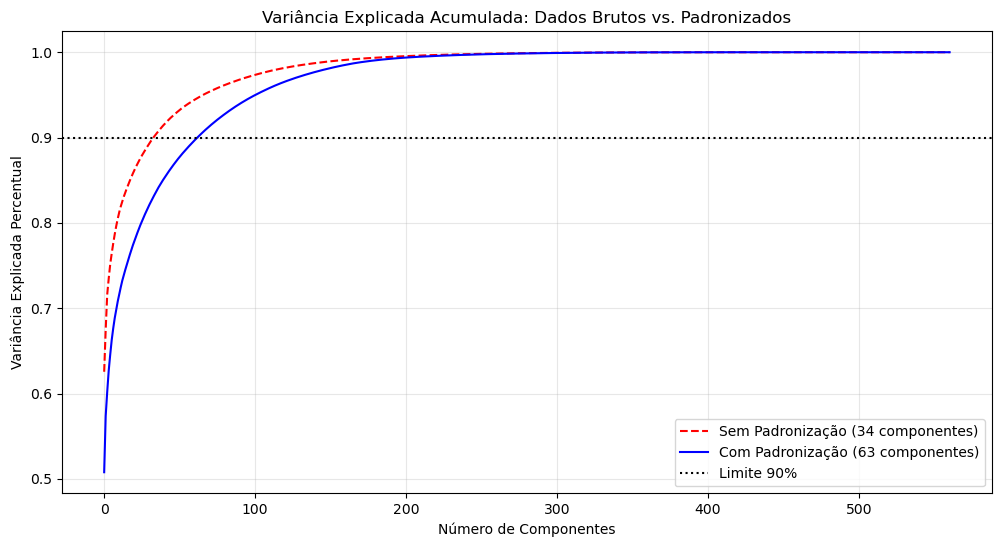

Componentes para 90% (Sem Padronização): 34
Componentes para 90% (Com Padronização): 63
CPU times: total: 4.28 s
Wall time: 3.13 s


In [5]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Configuração do caminho e carga dos dados
path_base = Path(r'C:\Users\renna\EBAC\MOD27\dataset\UCI HAR Dataset')

features = pd.read_csv(path_base / "features.txt", header=None, names=['nome_var'], sep="#").squeeze("columns")
X_train = pd.read_csv(path_base / "train/X_train.txt", delim_whitespace=True, header=None, names=features.tolist())

# --- 2. PCA SEM Padronização ---
pca_raw = PCA().fit(X_train)
expl_var_raw = pca_raw.explained_variance_ratio_
cum_var_raw = np.cumsum(expl_var_raw)

# --- 3. PCA COM Padronização ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca_scaled = PCA().fit(X_train_scaled)
expl_var_scaled = pca_scaled.explained_variance_ratio_
cum_var_scaled = np.cumsum(expl_var_scaled)

# --- 4. Função para encontrar n componentes para 90% de variância ---
def get_n_components(cum_var, threshold=0.90):
    return np.argmax(cum_var >= threshold) + 1

n_raw = get_n_components(cum_var_raw)
n_scaled = get_n_components(cum_var_scaled)

# --- 5. Visualização Comparativa ---
plt.figure(figsize=(12, 6))

plt.plot(cum_var_raw, label=f'Sem Padronização ({n_raw} componentes)', color='red', linestyle='--')
plt.plot(cum_var_scaled, label=f'Com Padronização ({n_scaled} componentes)', color='blue')

plt.axhline(y=0.90, color='black', linestyle=':', label='Limite 90%')
plt.title('Variância Explicada Acumulada: Dados Brutos vs. Padronizados')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Percentual')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Componentes para 90% (Sem Padronização): {n_raw}")
print(f"Componentes para 90% (Com Padronização): {n_scaled}")

A padronização aumentou a necessidade de componentes de **34 para 63** para manter **90% da variância explicada**.  
Embora o modelo **sem padronização** seja mais compacto, a versão **padronizada** é tecnicamente mais confiável, pois garante que nenhum sensor — como um **giroscópio com valores mais altos** — domine a análise sobre um **acelerômetro com valores menores**.

Dessa forma, a padronização permite capturar de maneira mais equilibrada a **essência de cada atividade física**, resultando em uma representação mais justa e robusta dos dados.


## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [10]:
%%time
import pandas as pd
import time
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# 1. Configuração do caminho e carga dos dados
path_base = Path(r'C:\Users\renna\EBAC\MOD27\dataset\UCI HAR Dataset')

features = pd.read_csv(path_base / "features.txt", header=None, names=['nome_var'], sep="#").squeeze("columns")

X_train = pd.read_csv(path_base / "train/X_train.txt", delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(path_base / "train/y_train.txt", header=None, names=['cod_label'])
X_test = pd.read_csv(path_base / "test/X_test.txt", delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(path_base / "test/y_test.txt", header=None, names=['cod_label'])

# --- 2. ÁRVORE SEM PADRONIZAÇÃO (10 Componentes) ---
pca_raw = PCA(n_components=10)
X_train_pca_raw = pca_raw.fit_transform(X_train)
X_test_pca_raw = pca_raw.transform(X_test)

clf_raw = DecisionTreeClassifier(random_state=42, ccp_alpha=0.001)
clf_raw.fit(X_train_pca_raw, y_train)

acc_train_raw = accuracy_score(y_train, clf_raw.predict(X_train_pca_raw))
acc_test_raw = accuracy_score(y_test, clf_raw.predict(X_test_pca_raw))

# --- 3. ÁRVORE COM PADRONIZAÇÃO (10 Componentes) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca_scaled = PCA(n_components=10)
X_train_pca_scaled = pca_scaled.fit_transform(X_train_scaled)
X_test_pca_scaled = pca_scaled.transform(X_test_scaled)

clf_scaled = DecisionTreeClassifier(random_state=42, ccp_alpha=0.001)
clf_scaled.fit(X_train_pca_scaled, y_train)

acc_train_scaled = accuracy_score(y_train, clf_scaled.predict(X_train_pca_scaled))
acc_test_scaled = accuracy_score(y_test, clf_scaled.predict(X_test_pca_scaled))

# --- 4. EXIBIÇÃO DOS RESULTADOS ---
print(f"{'Cenário':<30} | {'Treino':<10} | {'Teste':<10}")
print("-" * 55)
print(f"{'Sem Padronização (10 comp)':<30} | {acc_train_raw:.2%} | {acc_test_raw:.2%}")
print(f"{'Com Padronização (10 comp)':<30} | {acc_train_scaled:.2%} | {acc_test_scaled:.2%}")

<timed exec>:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
<timed exec>:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead


Cenário                        | Treino     | Teste     
-------------------------------------------------------
Sem Padronização (10 comp)     | 89.27% | 82.42%
Com Padronização (10 comp)     | 85.87% | 76.72%
CPU times: total: 4.81 s
Wall time: 3.82 s


Para este problema específico, com uma **restrição severa de apenas 10 componentes principais**, a **não padronização** apresentou melhores resultados.  
Isso indica que as variáveis com **maior variância original** carregam os **sinais mais discriminatórios** para a classificação de atividades.

A **padronização**, ao equalizar as variâncias entre as variáveis, exige um **número maior de componentes principais** para capturar a mesma qualidade de informação — como observado na *Atividade 1*, onde foram necessários **63 componentes** para manter o mesmo nível informacional.


----------